In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from utils import rmspe

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import optim, nn

In [4]:
train_targets = pd.read_csv('train.csv')

In [5]:
import os
import re
stock_ids = sorted(
    [int(re.sub('stock_id=', '', x)) for x in os.listdir('book_train.parquet')])

In [6]:
stock_id = stock_ids[19]

In [7]:
book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
trades = pd.read_parquet('trade_train.parquet/stock_id=' + str(stock_id))

In [9]:
book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
book['log_price'] = np.log(book['wap'])
book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
book['square_return'] = book['log_return'] ** 2
book = book[~book['log_return'].isnull()]
book['stock_id'] = stock_id

In [10]:
book = pd.merge(book, train_targets, how='left', on=['time_id', 'stock_id'])

In [45]:
X = pd.pivot_table(book, 
                   values='log_return', 
                   columns=['seconds_in_bucket'], 
                   index='time_id', aggfunc='last')

X = X.fillna(0)
y = train_targets[train_targets.stock_id == stock_id].set_index('time_id')['target'].loc[X.index]
#X = X.values

In [158]:
train_inds = np.random.choice(range(len(y)), replace=False, size=int(0.75*len(y)))
test_inds = np.delete(range(len(y)), train_inds)

X_train = X.values[train_inds]
X_test = X.values[test_inds]

y_train = y.values[train_inds]
y_test = y.values[test_inds]

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [159]:
class SQAC(nn.Module):
    '''Square activation function'''
    def __init__(self):
        super().__init__()
        
    def forward(self, inp):
        return torch.square(inp)
        

In [182]:
model = nn.Sequential(nn.BatchNorm1d(X_train.shape[1]),
                     nn.Linear(X_train.shape[1], 1), 
                     SQAC())

In [183]:
def my_loss(y_true, y_pred):
    return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

In [184]:
opt = optim.Adam(model.parameters(), lr=1e-4)

In [185]:
batch_size = 64
n_step = 1000

In [186]:
loss_history = []

In [187]:
for n in trange(n_step):
    batch_inds = np.random.choice(range(X_train.shape[0]), replace=False, size=batch_size)
    X_batch = X_train[batch_inds]
    y_batch = y_train[batch_inds]
    
    y_pred = model(X_batch)[:, 0]
    
    loss = my_loss(y_batch, y_pred)
    loss.backward()
    
    opt.step()
    opt.zero_grad()
    
    loss_history.append(loss.detach().numpy())
    
    

100%|██████████| 1000/1000 [00:05<00:00, 175.72it/s]


In [188]:
loss_history[100]

array(0.68393317)

In [189]:
loss = my_loss(y_train, model(X_train)[:, 0])
loss

tensor(0.4888, dtype=torch.float64, grad_fn=<SqrtBackward>)

In [190]:
loss = my_loss(y_test, model(X_test)[:, 0])
loss

tensor(0.5922, dtype=torch.float64, grad_fn=<SqrtBackward>)

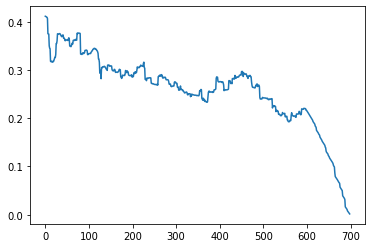

In [180]:
plt.plot(np.convolve(loss_history, np.ones(100) / 100)[400: ])

In [181]:
loss_history

[array(5.88670437),
 array(5.87633503),
 array(5.7874231),
 array(5.41063703),
 array(4.74269203),
 array(4.61055861),
 array(4.88058572),
 array(4.62185576),
 array(4.86900058),
 array(4.63123375),
 array(4.07664199),
 array(3.82458409),
 array(4.00472417),
 array(3.82972885),
 array(3.55858477),
 array(3.49896814),
 array(3.16288939),
 array(3.19575008),
 array(3.04356229),
 array(2.80551419),
 array(2.95247897),
 array(2.88486797),
 array(2.28917945),
 array(2.23882705),
 array(2.11746553),
 array(1.97684421),
 array(1.76209423),
 array(1.96566659),
 array(1.39367022),
 array(1.40481519),
 array(1.18102852),
 array(1.02105569),
 array(0.95810691),
 array(0.80371005),
 array(0.96073189),
 array(0.68724808),
 array(0.60637568),
 array(0.56880127),
 array(0.88805168),
 array(0.85483875),
 array(2.20898793),
 array(0.65774638),
 array(0.88575355),
 array(0.806218),
 array(1.28492851),
 array(0.80491734),
 array(0.65292217),
 array(0.48166883),
 array(0.58211087),
 array(0.80049748),
 ar